# Py: Linear Programming
**This notebook was originally created by Amanda Aitken for the Data Analytics Applications subject, as *Tutorial 10 exercise - linear programming in Python* in the *DAA M08 Business optimisation* module.**

**The Data Analytics Application is a Fellowship Applications (Module 3) subject with the Actuaries Institute that aims to teach students how to apply a range of data analytics skills, such as neural networks, natural language processing, unsupervised learning and optimisation techniques, together with their professional judgement, to solve a variety of complex and challenging business problems. The business problems used as examples in this subject are drawn from a wide range of industries.**

**Find out more about the course [here](https://www.actuaries.asn.au/education-program/fellowship/subjects-and-syllabus/data-analytics-applications-subject).**

### Scenario
Best Toy is a toy maker that owns three warehouses in different locations. Best Toy only produces one type of toy.

Best Toy supplies four major toy retailers. Each quarter, the toy retailers submit orders to Best Toy to be delivered weekly.

Best Toy incurs the following costs:

 * costs to produce each toy—this cost varies by warehouse and by retailer (each retailer has slightly different specifications for their version of the toy); and
 * costs to deliver each toy—this cost varies by the distance between the warehouse and the retailer.

Each of Best Toy’s warehouses has a maximum production capacity. Assume that all warehouses are open and no additional costs are incurred.

Best Toy must fulfil the orders from each retailer.

Best Toy wishes to determine how many toys to produce at each of its warehouses for each retailer to optimise its costs. Let:
 * $w_{i}$ denote each warehouse, where $i∈{1,2,3}$;
 * $r_{j}$ denote each retailer, where $j∈{1,2,3,4}$;
 * $p_{i,j}$ denote the cost of producing one toy by warehouse $i (w_{i})$ for retailer $j (r_{j})$;
 * $d_{i,j}$ denote the cost of delivering one toy from warehouse $i (w_{i})$ to retailer $j (r_{j})$;
 * $q_{i,j}$ denote the quantity of toys produced by warehouse $i (w_{i})$ for retailer $j (r_{j})$;
 * $D_{j}$ denote the quantity of toys ordered by retailer $j (r_{j})$; and
 * $W_{i}$ denote the production capacity of warehouse $i (w_{i})$. 

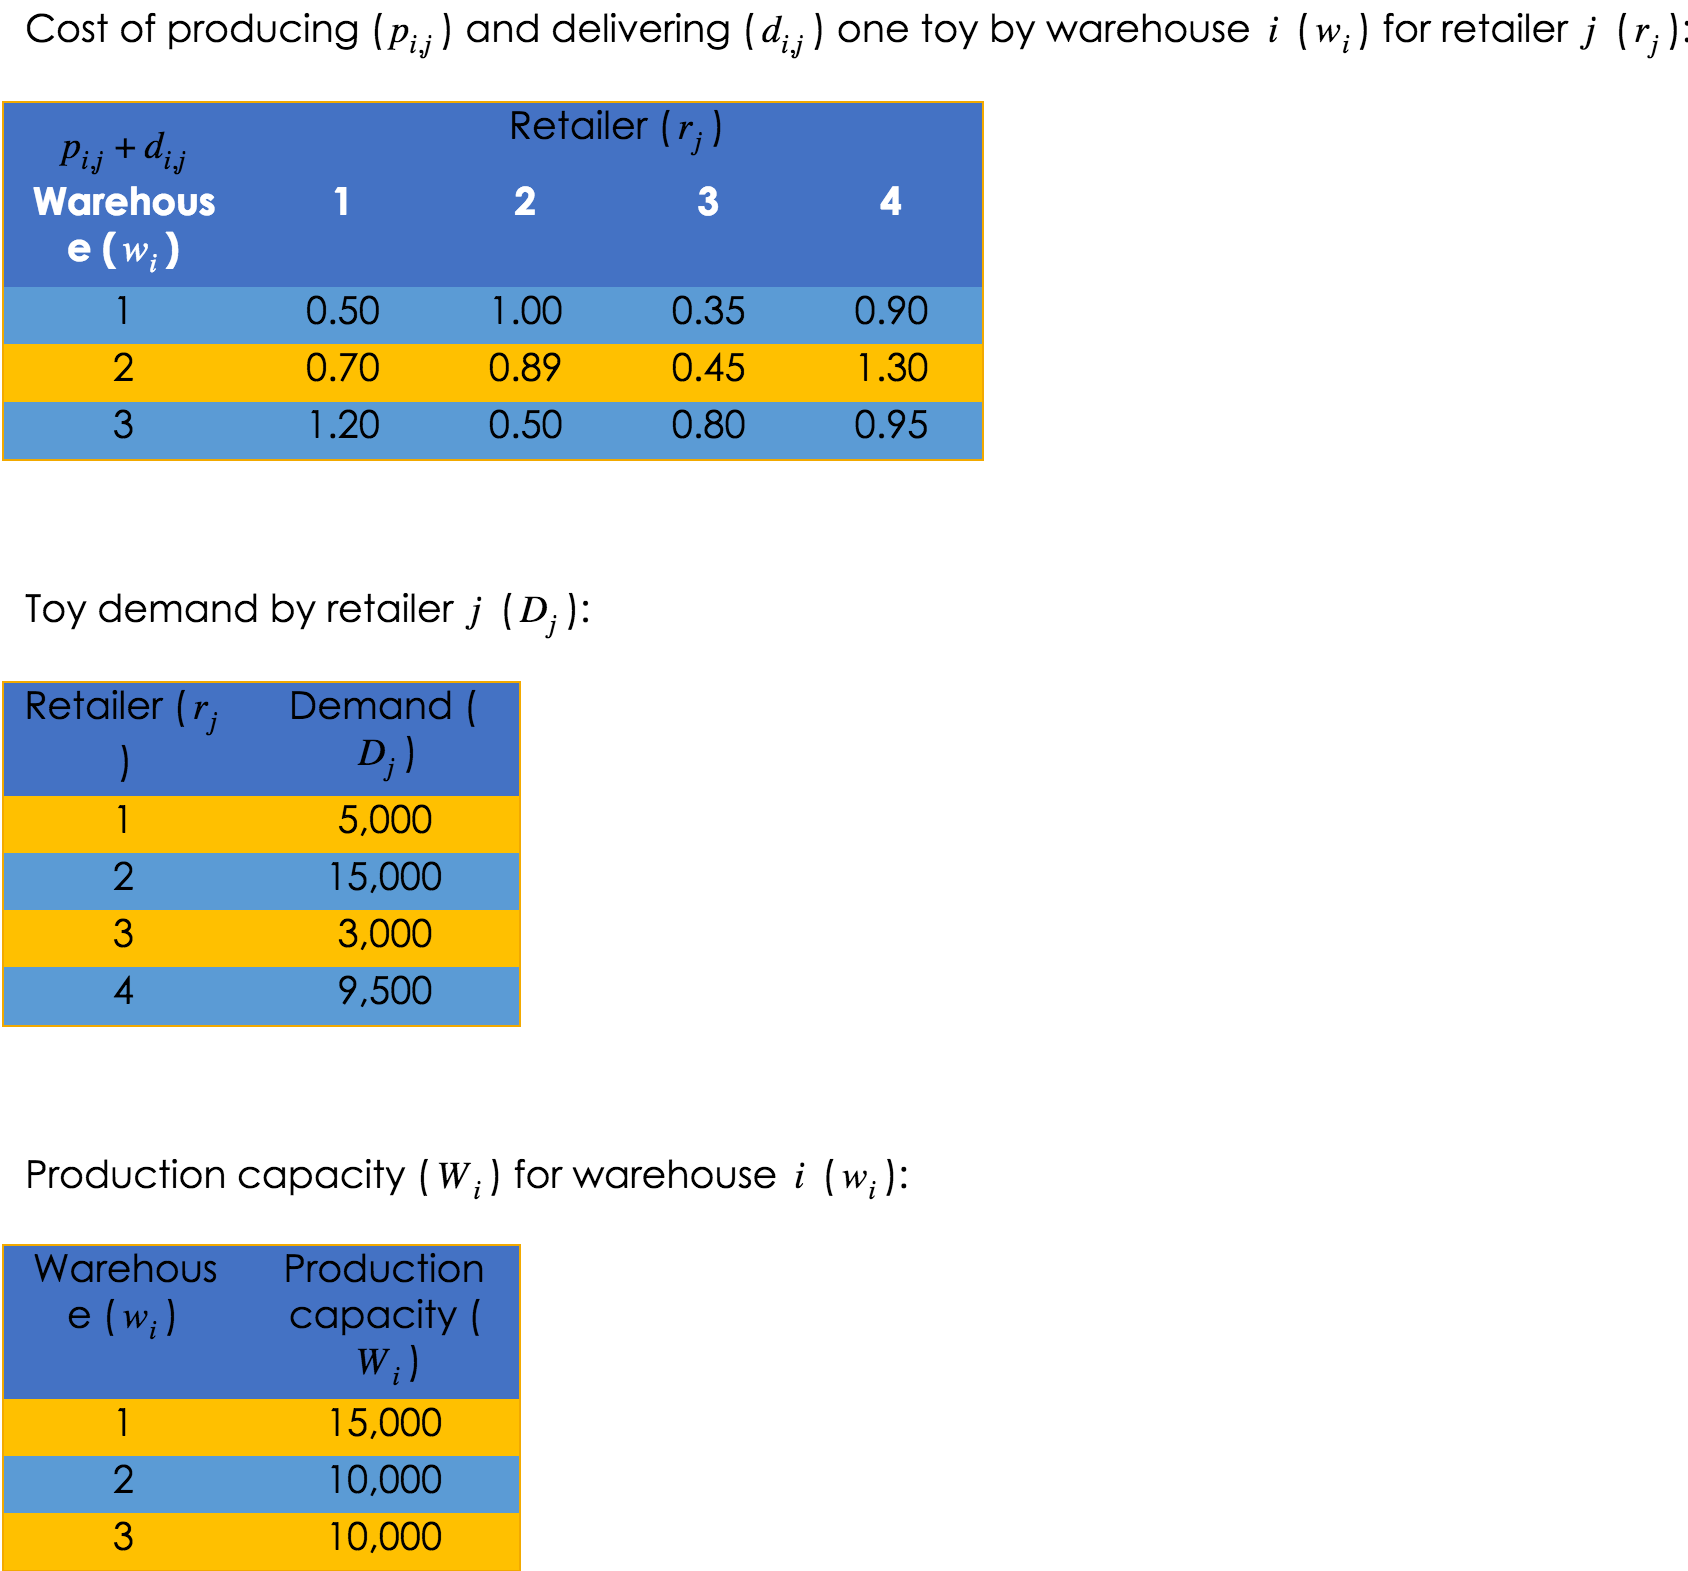

This notebook uses the following data and the scipy.optimize package (this video might help: https://www.youtube.com/watch?v=cXHvC_FGx24) to find an optimal solution to the warehouse supply management problem outlined above.

## Packages
This section installs packages that will be required for this exercise/case study.

In [1]:
import numpy as np
from scipy.optimize import minimize

# To make the output of numpy arrays in this notebook easier to read,
# the line of code below specifies that integers and floats in numpy arrays
# should be printed with a comma to indicate place value,
# with 0 decimal places for floats, and
# with the automatic conversion of small numbers to scientific notation suppressed. 
np.set_printoptions(formatter={'int':'{:,}'.format,'float':'{:,.0f}'.format},
                    suppress=True)

## Variables
This section sets out the variables that will be referenced in the optimisation problem.

In [2]:
# Create a range object for the warehouses to make it easier to iterate over them.
warehouses_total = 3
warehouses = range(warehouses_total)

# Create a range object for the retailers to make it easier to iterate over them.
retailers_total = 4
retailers = range(retailers_total)

In [3]:
# Create the cost variables that have fixed values.
# The costs in this variable reflect both production and delivery costs
# for each warehouse/retailer combination.
costs = [[0.5,1,0.35,0.9],
        [0.7,0.89,0.45,1.3],
        [1.2,0.5,0.8,0.95]]

In [4]:
# Initialise the production quantities matrix.
initial_quantities = [[2500,2500,2500,2500],
                   [2500,2500,2500,2500],
                   [2500,2500,2500,2500]]

## Objective
This section defines the objective function that will be optimised.

In [5]:
# Specify the objective as being to minimise the total cost of production.
# This is defined in the funtion 'objective' where the total production quanities
# are an input to the function, which will then use a cost matrix to calculate
# the total cost for the given quantities.
def objective(x):
    production_quantities = np.reshape(x,(warehouses_total, retailers_total))
        # The scipy.optimize.minimize function needs an array of
        # initial 'guesses' for production quantities, so this
        # reshape expression is used to turn the production quantities vector
        # into a matrix of warehouse rows and retailer columns to make it
        # easier to manipulate.
    total_cost = np.sum(np.multiply(production_quantities,costs))
        # np.multiply is used to calculate the element-wise product of the
        # production_quantities and costs matrices.
        # np.sum() calculates the sum of all the values in the resulting
        # matrix. 
    return total_cost

In [6]:
# Test that the objective function works as expected.
test_quantities = initial_quantities

test_outcome = objective(test_quantities)
print('${:,.0f}'.format(test_outcome))

$23,850


The total production and delivery cost of the initial quantities, worked out by manually multiplying the individual initial quantities and costs, should be $23,850. This is the cost given by the objective function applied to the initial quantities so the objective function seems to be working.

## Constraints
This section sets out the constraints that will be imposed on the optimisation solution.

### Warehouse capacity constraint
The first constraint is that the amount produced at each warehouse must be less than or equal to the warehouse's capacity.

This is an inequality constraint, as the amount produced must be 'less than or equal' to something.

In the scipy.optimize package, these inequality constraints need to be expressed as:

***'inequality constraint' >= 0***


Therefore, the warehouse capacity constraint will be expressed as:

***warehouse capacity - warehouse production >= 0***





In [7]:
# Specify the capacity of each warehouse.
capacity = [15000,
            10000,
            10000]

# Create a function to define the warehouse capacity constraint.
def capacity_constraint(x):
    production_quantities = np.reshape(x,(warehouses_total, retailers_total))
        # The scipy.optimize.minimize function needs an array of
        # initial 'guesses' for production quantities, so this
        # reshape expression is used to turn the production quantities vector
        # into a matrix of warehouse rows and retailer columns to make it
        # easier to manipulate.
    constraint = capacity - np.sum(production_quantities,axis=1)
        # np.sum(x, axis=1) calculates the sum of all columns (retailers)
        # for each row (warehouse) in the matrix x.
        # This constraint therefore produces a vector of size 3, where
        # each element in the vector must be greater than or equal to 0.
    return constraint

# Specify that this first constraint is an inequality constraint
# with the constraint expression being calculated by the function 'capacity_constraint'
constraint1 = {'type':'ineq','fun':capacity_constraint}

In [8]:
# Test that the capacity_constraint function works as expected
test_quantities = [[2500,2500,2500,2500],
                   [2500,2500,2500,2500],
                   [2500,2500,2500,2500]]

test_outcome = capacity_constraint(test_quantities)
print(test_outcome)

[5,000 0 0]


This capacity constraint function seems to be doing what we expect - there is:
- excess capacity of 5,000 toys at Warehouse 1 (15,000 - 4x2,500);
- but no excess capacity at Warehouses 2 or 3 (10,000 - 4x2,500).

### Retailer demand constraint

The second constraint is that the amount produced for each retailer must be greater than or equal to the demand for that retailer.

This is again an inequality constraint and must be expressed as:

***'inequality constraint' >= 0***

Therefore, the retailer demand constraint will be expressed as:

***retailer production - retailer demand >= 0***

In [9]:
# Specify the demand of each retailer.
demand = [5000,
          15000,
          3000,
          9500]

# Create a function to define the retailer demand constraint.
def demand_constraint(x):
    production_quantities = np.reshape(x,(warehouses_total, retailers_total))
        # The scipy.optimize.minimize function needs an array of
        # initial 'guesses' for production quantities, so this
        # reshape expression is used to turn the production quantities vector
        # into a matrix of warehouse rows and retailer columns to make it
        # easier to manipulate.
    constraint = np.sum(production_quantities,axis=0)-demand
        # np.sum(x, axis=0) calculates the sum of all rows (warehouses)
        # for each column (retailers) in the matrix x.
        # This constraint therefore produces a vector of size 4, where
        # each element in the vector must be greater than or equal to 0.
    return constraint

# Specify that this second constraint is an inequality constraint
# with the constraint expression being calculated by the function 'demand_constraint'
constraint2 = {'type':'ineq','fun':demand_constraint}

In [10]:
# Test that the demand_constraint function works as expected
test_quantities = [[2500,2500,2500,2500],
                   [2500,2500,2500,2500],
                   [2500,2500,2500,2500]]

test_outcome = demand_constraint(test_quantities)
print(test_outcome)

[2,500 -7,500 4,500 -2,000]


This demand constraint function seems to be doing what we expect as there is:
- excess production of 2,500 toys for Retailer 1 (7,500 - 5,000);
- under production of 7,500 toys for Retailer 2 (7,500 - 15,000);
- excess production of 4,500 toys for Retailer 3 (7,500 - 3,000); and
- under production of 2,000 toys for Retailer 4 (7,500 - 9,500);

### Individual production constraint

The third constraint is that the amount produced for each retailer and each warehouse must be greater than or equal to zero.

This can be specified by creating a lower bound of 0 for each entry in the production_quantities matrix.

In [11]:
# Specify that there is a lower bound of 0 for each entry in the
# production_quantities matrix

bound = (0,100000)
    # This specifies that the lower bound is 0.
    # An upper bound of 100,000 has also been set as the bound
    # component of the SciPy Optimizer needs a lower and upper bound.
bounds = (bound,)*warehouses_total*retailers_total
print(bounds)

((0, 100000), (0, 100000), (0, 100000), (0, 100000), (0, 100000), (0, 100000), (0, 100000), (0, 100000), (0, 100000), (0, 100000), (0, 100000), (0, 100000))


## Solve the optimisation problem by minimising the objective function

In [12]:
# Create a list of all the constraints that will be imposed on the solution.
constraints = [constraint1, constraint2]

In [13]:
# Solve the optimisation problem using the scipy.optimize.minimize function.

# There are various methods that can be used in the scipy.optimize.minize function.
# These methods are listed below.

methods = ['Nelder-Mead',     # also known as Downhill Simplex, Amoeba or Polytope
           'Powell',
           'CG',              # Conjugate Gradient
           'BFGS',            # Broyden–Fletcher–Goldfarb–Shanno (quasi-Newton method)
           'Newton-CG',       # Newton Conjugate Gradient (Newton method)
           'L-BFGS-B',        # Limited-memory BFGS (quasi-Newton method)
           'TNC',             # Truncated Newton (quasi-Newton method)
           'COBYLA',          # Constrained Optimization BY Linear Approximation
           'SLSQP',           # Sequential Least Squares Programming 
           'trust-constr',    # Trust-Region Constrained
           'dogleg',          # Trust-Region dogleg
           'trust-ncg',       # Trust-Region Newton Conjugate Gradient
           'trust-krylov',    # Trust-Region Truncated Generalized Lanczos
           'trust-exact']     # Trust-Region Nearly Exact

method = methods[8]

solution = minimize(objective,initial_quantities,
                    method = method,
                    bounds = bounds,
                    constraints = constraints)

According to the scipy.optimize.minimize documentation, if the optimisation method is not specified in the call to minimize, it is chosen to be one of the following methods, depending on whether the problem has constraints or bounds:
- BFGS (cannot handle constraints or bounds);
- L-BFGS-B (cannot handle constraints); or
- SLSQP (can handle constraints and bounds).

As an additional exercise, you could try running the optimiser using each of the different methods available in scipy.optimize.minimize.

Do they all work? If not, what error messages do they produce?

In [14]:
# Reshape the output of the optimiser so that it is easier to visualise
# the optimiser's selected quantities for each warehouse (row) and
# retailer (column).
solution_quantities = np.reshape(np.round(solution.x,0),
                                 (warehouses_total,retailers_total))

# Print the solution to the problem.
print('The production quantities that minimise the cost of production')
print('for each warehouse (rows) and each retailer (columns) are:')
print(solution_quantities)

# Print the cost of the optimised solution.
print('\nThe total cost using these production quantities is:')
print('${:,.0f}'.format(objective(solution_quantities)))

The production quantities that minimise the cost of production
for each warehouse (rows) and each retailer (columns) are:
[[5,000 0 500 9,500]
 [0 5,000 2,500 0]
 [0 10,000 0 0]]

The total cost using these production quantities is:
$21,800
